In [63]:
# Extract visible R and NIR bands
import rasterio
from rasterio.windows import Window
import numpy as np

image_file = "20210330_111622_19_106a_3B_AnalyticMS_SR.tif"

# Load red and NIR bands - note all PlanetScope 4-band images have band order BGRN
with rasterio.open(image_file) as src:
    band_red = src.read(3, window=Window(2500, 2500, 200, 200)).astype(np.float32)

with rasterio.open(image_file) as src:
    band_nir = src.read(4, window=Window(2500, 2500, 200, 200)).astype(np.float32)
    
# convert NoData to Nan    
band_red[band_red == src.nodata] = np.nan
band_nir[band_nir == src.nodata] = np.nan

In [64]:
# Converting the pixel values to TOA Reflectance
from xml.dom import minidom

xmldoc = minidom.parse("20210330_111622_19_106a_3B_AnalyticMS_metadata.xml")
nodes = xmldoc.getElementsByTagName("ps:bandSpecificMetadata")

# XML parser refers to bands by numbers 1-4
coeffs = {}
for node in nodes:
    bn = node.getElementsByTagName("ps:bandNumber")[0].firstChild.data
    if bn in ['1', '2', '3', '4']:
        i = int(bn)
        value = node.getElementsByTagName("ps:reflectanceCoefficient")[0].firstChild.data
        coeffs[i] = float(value)

In [65]:
# Multiply the band values by the TOA Reflectance coefficients
band_red = band_red * coeffs[3]
band_nir = band_nir * coeffs[4]

In [66]:
# Calculate NDVI
# Allow division by zero
numpy.seterr(divide='ignore', invalid='ignore')

# Calculate NDVI
ndvi = (band_nir - band_red) / (band_nir + band_red)

# 1-99% contrast stretch
vmin, vmax = np.nanpercentile(ndvi, (1,99))

In [53]:
# Save NDVI image
# Set spatial characteristics of the output object to mirror the input
kwargs = src.meta
kwargs.update(
    dtype=rasterio.float32,
    count = 1)

# Create the file
with rasterio.open('ndvi.tif', 'w', **kwargs) as dst:
        dst.write_band(1, ndvi.astype(rasterio.float32))

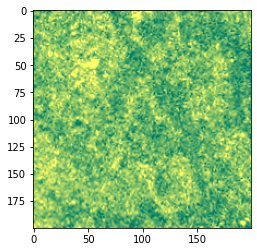

In [68]:
# visualize the ndvi map
import matplotlib.pyplot as plt
# plt.imsave("ndvi_cmap.png", ndvi, cmap=plt.cm.summer)
plt.imshow(ndvi, cmap=plt.cm.summer, vmin=vmin, vmax=vmax)
plt.show()